In [1]:
# Import packages
 # import fuzzywizzy?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pymongo
import string
import nltk
import re
import os
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')



src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

# helper functions
from d02_processing.cleaning_signatures import sorted_signatures
from d02_processing.cleaning_signatures import cleaned_signatures
from d01_utils.mongo_cursor_creator import mongo_cursor

# Load the "autoreload" extension
%load_ext autoreload

# reload modules so that as you change code in src, it gets loaded
%autoreload

%matplotlib inline

In [2]:
# import the unique signatures from the database
sigs_from_cursor = mongo_cursor()
sigs_from_cursor[0:5]

['',
 '\nAll about helping others achieve healthy, beautiful natural hair. Check me out on YouTube 😊!\nhttps://www.youtube.com/c/TriniGirlNatural\n\nFollow me on instagram for my daily doings:occasion9::\nhttp://instagram.com/trinigirlnatural\n\nSave\n\n\nSave\n\n\nSave\n\n\nSave\n\n\nSave\n\n',
 'Poo: Deva NoPoo\nCo-Wash: Suave Naturals\nRinse Out/Leave in: Deva One Condition\nProducts: Deva ArcAngell & Deva Mister Right\n\n2b/c, overly porous, med/course hair ',
 'Have Patience :afro:\n\n\n\n\n[SIGPIC][/SIGPIC]',
 "CG since Feb '09 : )\nThick 3b currently using...\nLow-Poo: TJ's Nourish Spa shampoo\nConditioner: TJ's Nourish Spa condish, Garnier Fructis (the one w/o cones)\nDT's: Shea butter, Olive oil\nLeave-In: L'oreal Paris Ever Pure Rosemary Mint\nStylers: HETT gel, L'oreal Paris clear minded gel\nAlso love ACV rinses : )"]

In [3]:
# sort the signatures
raw_characteristics_df = sorted_signatures(sigs_from_cursor)
raw_characteristics_df.head()

,curl_pattern,density,porosity,texture,products
0,NaN,NaN,NaN,NaN,
1,NaN,NaN,NaN,NaN,all about helping others achieve healthy beau...
2,2b,NaN,NaN,course,poo deva nopoo co wash suave naturals rinse ou...
3,NaN,NaN,NaN,NaN,have patience afro sigpic sigpic
4,3b,thick,NaN,NaN,since feb 09 currently using low poo tj s nour...


In [4]:
cleaned_df = cleaned_signatures(raw_characteristics_df)
cleaned_df.head()

,curl_pattern,density,porosity,texture,products
2,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...
4,3b,thick,NaN,NaN,since feb 09 currently using low poo tj s nour...
7,NaN,NaN,high,fine,dense normal to modified for washing and deta...
11,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...
12,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...


In [5]:
cleaned_df.to_csv('../../data/02_intermediate//cleaned_and_sorted.csv')

In [6]:
# make a data fram with no nulls in the different characteristics
curl_pattern_no_nan_df = cleaned_df[pd.notnull(cleaned_df['curl_pattern'])]
curl_pattern_no_nan_df['curl_catagory'] = pd.Categorical(curl_pattern_no_nan_df.curl_pattern)
curl_pattern_no_nan_df["curl_catagory"] = curl_pattern_no_nan_df["curl_catagory"].cat.codes
print(curl_pattern_no_nan_df.describe())
curl_pattern_no_nan_df.head()

       curl_catagory
count    7405.000000
mean        4.342201
std         1.686252
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         9.000000


,curl_pattern,density,porosity,texture,products,curl_catagory
2,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,2
4,3b,thick,NaN,NaN,since feb 09 currently using low poo tj s nour...,5
11,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,7
12,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,4
13,3b,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,5


In [7]:
curl_pattern_no_nan_df.to_csv('../../data/02_intermediate/no_nan_curl_pattern_df.csv')

In [8]:
cleaned_df['curl_catagory'] = pd.Categorical(cleaned_df.curl_pattern)
cleaned_df.dtypes


curl_pattern       object
density            object
porosity           object
texture            object
products           object
curl_catagory    category
dtype: object

In [9]:
cleaned_df["curl_catagory"] = cleaned_df["curl_catagory"].cat.codes
cleaned_df.head()

,curl_pattern,density,porosity,texture,products,curl_catagory
2,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,2
4,3b,thick,NaN,NaN,since feb 09 currently using low poo tj s nour...,5
7,NaN,NaN,high,fine,dense normal to modified for washing and deta...,-1
11,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,7
12,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,4


In [11]:
cleaned_df.products

1        molly didn t want her hair to look pretty that...
2        mix of and wash recently changed to using low ...
3        mix of and wash recently changed to using low ...
5         shampoo devacurl nopoo condition detangle gio...
6         shampoo devacurl nopoo condition detangle gio...
7        natural since 2001 curl type with some length ...
8        natural since 2001 curl type with some length ...
11        hair  strands avatar pic march 20th 2013 co w...
12        curly hair is someg that every girl with stra...
13        color treated 5 years co wash suave naturals ...
14        color treated 5 years co wash suave naturals ...
15       since 5 24 09 still trying to figure everyg ou...
16       since 5 24 09 still trying to figure everyg ou...
17        very very coarse and protein sensitive shampo...
18        very very coarse and protein sensitive shampo...
20       i am a curly with very short down to my earlob...
21       i am a curly with very short down to my earlob.

## n-gram Play
DO keep in mind that this is just for the products that have a curl pattern, there are more without

In [10]:
# Check on frequency of n-grams

def generate_ngrams(s, n):
    # Convert to lowercases
    s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [11]:
# all quimtagrams in the product set

result = [generate_ngrams(x, 5) for x in curl_pattern_no_nan_df['products']]
result

[['poo deva nopoo co wash',
  'deva nopoo co wash suave',
  'nopoo co wash suave naturals',
  'co wash suave naturals rinse',
  'wash suave naturals rinse out',
  'suave naturals rinse out leave',
  'naturals rinse out leave in',
  'rinse out leave in deva',
  'out leave in deva one',
  'leave in deva one condition',
  'in deva one condition products',
  'deva one condition products deva',
  'one condition products deva arcangell',
  'condition products deva arcangell deva',
  'products deva arcangell deva mister',
  'deva arcangell deva mister right',
  'arcangell deva mister right c',
  'deva mister right c overly',
  'mister right c overly porous',
  'right c overly porous hair'],
 ['since feb 09 currently using',
  'feb 09 currently using low',
  '09 currently using low poo',
  'currently using low poo tj',
  'using low poo tj s',
  'low poo tj s nourish',
  'poo tj s nourish spa',
  'tj s nourish spa shampoo',
  's nourish spa shampoo conditioner',
  'nourish spa shampoo condition

In [12]:
# put all the ngrams in one list rather than a list of lists
quintagram = []
for r in result:
    for x in r:
        quintagram.append(x)
quintagram[:50]  

['poo deva nopoo co wash',
 'deva nopoo co wash suave',
 'nopoo co wash suave naturals',
 'co wash suave naturals rinse',
 'wash suave naturals rinse out',
 'suave naturals rinse out leave',
 'naturals rinse out leave in',
 'rinse out leave in deva',
 'out leave in deva one',
 'leave in deva one condition',
 'in deva one condition products',
 'deva one condition products deva',
 'one condition products deva arcangell',
 'condition products deva arcangell deva',
 'products deva arcangell deva mister',
 'deva arcangell deva mister right',
 'arcangell deva mister right c',
 'deva mister right c overly',
 'mister right c overly porous',
 'right c overly porous hair',
 'since feb 09 currently using',
 'feb 09 currently using low',
 '09 currently using low poo',
 'currently using low poo tj',
 'using low poo tj s',
 'low poo tj s nourish',
 'poo tj s nourish spa',
 'tj s nourish spa shampoo',
 's nourish spa shampoo conditioner',
 'nourish spa shampoo conditioner tj',
 'spa shampoo condition

In [15]:
quintagram_df = pd.DataFrame({'quintagrams': quintagram})
quintagram_df.quintagrams.value_counts()

co wash suave naturals coconut                   86
shea moisture curl enhancing smoothie            47
as i am coconut cowash                           36
leave in kinky curly knot                        34
trader joe s tea tree                            33
in kinky curly knot today                        32
suave naturals coconut rinse out                 30
co wash as i am                                  29
herbal essences set me up                        28
giovanni tea tree triple treat                   28
order of the curly crusaders                     26
gvp conditioning balm leave in                   25
co wash suave tropical coconut                   25
leave in giovanni direct leave                   23
as i am leave in                                 23
the order of the curly                           22
joe s tea tree tingle                            21
in giovanni direct leave in                      21
low poo giovanni 50 50                           21
still trying

In [16]:
# Here is a different less ordered way to do it
Counter(quintagram)

Counter({'mix of and wash recently': 4,
         'of and wash recently changed': 4,
         'and wash recently changed to': 4,
         'wash recently changed to using': 4,
         'recently changed to using low': 4,
         'changed to using low sulfate': 4,
         'to using low sulfate shampoos': 4,
         'using low sulfate shampoos i': 4,
         'low sulfate shampoos i love': 4,
         'sulfate shampoos i love it': 4,
         'shampoos i love it my': 4,
         'i love it my hair': 4,
         'love it my hair needs': 4,
         'it my hair needs all': 4,
         'my hair needs all residue': 4,
         'hair needs all residue removed': 4,
         'needs all residue removed to': 4,
         'all residue removed to get': 4,
         'residue removed to get any': 4,
         'removed to get any volume': 4,
         'to get any volume conditioner': 4,
         'get any volume conditioner kinky': 4,
         'any volume conditioner kinky curly': 4,
         'volume cond

In [17]:
quadgram_list_of_lists = [generate_ngrams(x, 4) for x in curl_pattern_no_nan_df['products']]

quadragrams = []
for single_list in quadgram_list_of_lists:
    for x in single_list:
        quadragrams.append(x)
        
quadragram_df = pd.DataFrame({'quadragrams': quadragrams})
test = dict(quadragram_df.quadragrams.value_counts())
test

{'co wash suave naturals': 195,
 'kinky curly knot today': 104,
 'wash suave naturals coconut': 88,
 'giovanni direct leave in': 73,
 'suave naturals tropical coconut': 66,
 'giovanni smooth as silk': 66,
 'la looks sport gel': 64,
 'herbal essences totally twisted': 63,
 'kinky curly curling custard': 59,
 'shea moisture curl enhancing': 52,
 'as i am coconut': 51,
 'rinse out leave in': 48,
 'moisture curl enhancing smoothie': 48,
 'co wash suave coconut': 45,
 'trying to figure out': 43,
 'leave in suave naturals': 41,
 'trader joe s nourish': 41,
 'la looks sports gel': 40,
 'garnier fructis triple nutrition': 39,
 'tresemme naturals nourishing moisture': 38,
 'leave in kinky curly': 38,
 'but lots of it': 37,
 'conditioning balm leave in': 37,
 'suave naturals coconut conditioner': 37,
 'in kinky curly knot': 37,
 'kinky curly come clean': 36,
 'i am coconut cowash': 36,
 'leave in giovanni direct': 35,
 'set me up gel': 35,
 'cowash suave naturals coconut': 34,
 'joe s tea tree':

## Models for curl pattern predictors


In [58]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features = tfidf.fit_transform(curl_pattern_no_nan_df.products).toarray()
labels = curl_pattern_no_nan_df.curl_catagory
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
# df['category_id'] = df['Product'].factorize()[0]
# from io import StringIO
# category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'Product']].values)

curl_catagory_df = curl_pattern_no_nan_df[['curl_pattern', 'curl_catagory']].drop_duplicates().sort_values('curl_catagory')
curl_cat_key_dict = dict(curl_catagory_df.values)
curl_pattern_key_dict = dict(curl_catagory_df[['curl_catagory', 'curl_pattern']].values)
print(curl_cat_key_dict)
print(curl_pattern_key_dict)
curl_catagory_df

{'1c': 0, '2a': 1, '2b': 2, '2c': 3, '3a': 4, '3b': 5, '3c': 6, '4a': 7, '4b': 8, '4c': 9}
{0: '1c', 1: '2a', 2: '2b', 3: '2c', 4: '3a', 5: '3b', 6: '3c', 7: '4a', 8: '4b', 9: '4c'}


,curl_pattern,curl_catagory
636,1c,0
16,2a,1
46,2b,2
20,2c,3
2,3a,4
3,3b,5
6,3c,6
8,4a,7
27,4b,8
644,4c,9


In [20]:
N = 2
for curl_pattern, curl_cat in sorted(curl_cat_key_dict.items()):
    features_chi2 = chi2(features, labels == curl_cat)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    quadgrams = [v for v in feature_names if len(v.split(' ')) == 4]
    quintagrams = [v for v in feature_names if len(v.split(' ')) == 5]
    print("# '{}':".format(curl_pattern))
    #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))
    print("  . Most correlated quadgrams:\n. {}".format('\n. '.join(quadgrams[-N:])))
    print("  . Most correlated quintagrams:\n. {}".format('\n. '.join(quintagrams[-N:])))

# '1c':
  . Most correlated trigrams:
. jessicurl cleansing cream
. psalm 139 14
  . Most correlated quadgrams:
. poo mop hydrating shampoo
. tresemme naturals moisturizing conditioner
  . Most correlated quintagrams:
. tresemme naturals nourishing moisture conditioner
. suave naturals tropical coconut ro
# '2a':
  . Most correlated trigrams:
. healthy sexy hair
. ro ss caitlin
  . Most correlated quadgrams:
. normal elasticity low poo
. la looks mega hold
  . Most correlated quintagrams:
. stylers herbal essences totally twisted
. low poo cj daily fix
# '2b':
  . Most correlated trigrams:
. beauticurls li curl
. shampoo body shop
  . Most correlated quadgrams:
. wash vo5 kiwi lime
. yes cucumbers color protection
  . Most correlated quintagrams:
. low poo giovanni 50 50
. low poo devacurl low poo
# '2c':
  . Most correlated trigrams:
. coarse normal elasticity
. curly just wavy
  . Most correlated quadgrams:
. moisture coconut hibiscus hold
. li kinky curly knot
  . Most correlated qu

## Test a few different models

In [21]:
X = cleaned_df[['density', 'porosity', 'products', 'texture']]
y = cleaned_df.curl_catagory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [22]:
#Test some models now

X_train, X_test, y_train, y_test = train_test_split(curl_pattern_no_nan_df['products'], curl_pattern_no_nan_df['curl_pattern'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [23]:

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.285359
LogisticRegression        0.318448
MultinomialNB             0.309657
RandomForestClassifier    0.272654
Name: accuracy, dtype: float64

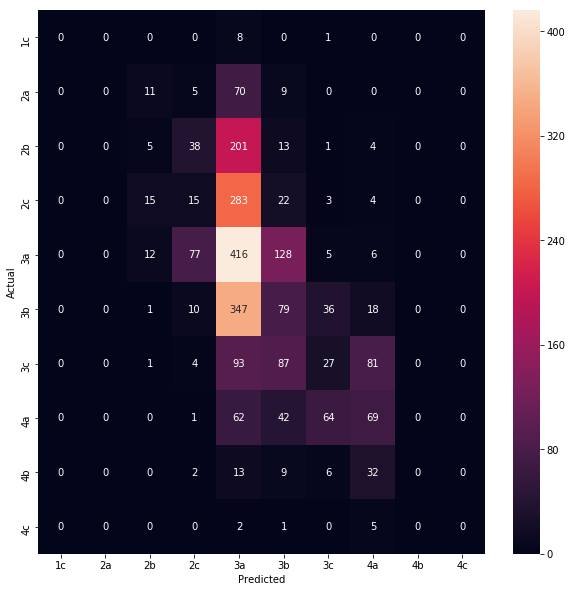

In [108]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=curl_catagory_df.curl_pattern.values, yticklabels=curl_catagory_df.curl_pattern.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [107]:
# somewhat imbalanced catagories
curl_pattern_no_nan_df.curl_pattern.value_counts()

3a    2019
3b    1455
2c    1066
3c     859
2b     762
4a     714
2a     314
4b     176
4c      23
1c      17
Name: curl_pattern, dtype: int64

In [ ]:
# Try ROC curve metric

## Try porosity models next

In [68]:
# make a data fram with no nulls in the different characteristics
porosity_no_nan_df = cleaned_df[pd.notnull(cleaned_df['porosity'])]
porosity_no_nan_df['porosity_catagory'] = pd.Categorical(porosity_no_nan_df.porosity)
porosity_no_nan_df["porosity_catagory"] = porosity_no_nan_df["porosity_catagory"].cat.codes
print(porosity_no_nan_df.describe())
porosity_no_nan_df.head()

       curl_catagory  porosity_catagory
count    2278.000000        2278.000000
mean        3.445566           1.125549
std         1.916889           0.796923
min        -1.000000           0.000000
25%         2.000000           0.000000
50%         4.000000           1.000000
75%         5.000000           2.000000
max         9.000000           2.000000


,curl_pattern,density,porosity,texture,products,curl_catagory,porosity_catagory
5,3b,thin,normal,NaN,shampoo devacurl nopoo condition detangle gio...,5,2
6,3c,thin,normal,NaN,shampoo devacurl nopoo condition detangle gio...,6,2
11,3b,medium,normal,fine,hair strands avatar pic march 20th 2013 co w...,5,2
13,3a,NaN,normal,medium,color treated 5 years co wash suave naturals ...,4,2
14,3b,NaN,normal,medium,color treated 5 years co wash suave naturals ...,5,2


In [85]:
# Classes are relitivly balanced
porosity_no_nan_df.texture.value_counts()

fine      886
medium    367
coarse    105
Name: texture, dtype: int64

In [82]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features_po = tfidf.fit_transform(porosity_no_nan_df.products).toarray()
labels_po = porosity_no_nan_df.porosity


In [79]:
#Test some models now

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_po, labels_po, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [80]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.430189
LogisticRegression        0.455638
MultinomialNB             0.445117
RandomForestClassifier    0.389819
Name: accuracy, dtype: float64

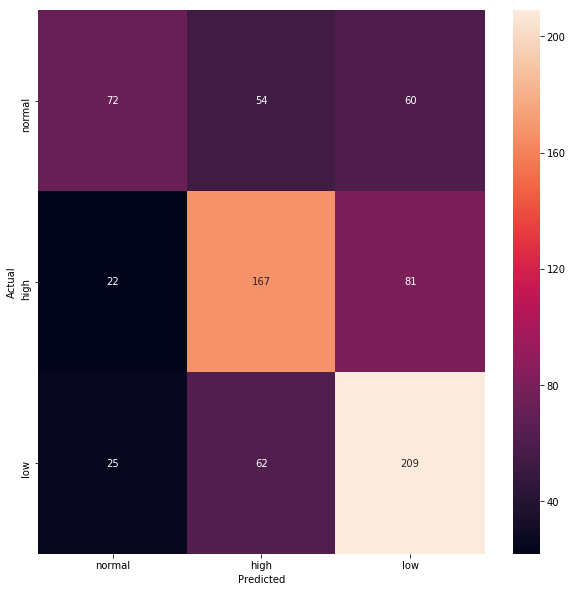

In [83]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(features_po, labels_po, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=porosity_no_nan_df.porosity.unique(), yticklabels=porosity_no_nan_df.porosity.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Density Models


In [109]:

# make a data fram with no nulls in the different characteristics
density_no_nan_df = cleaned_df[pd.notnull(cleaned_df['density'])]
density_no_nan_df['density_catagory'] = pd.Categorical(density_no_nan_df.density)
density_no_nan_df["density_catagory"] = density_no_nan_df["density_catagory"].cat.codes
print(density_no_nan_df.describe())
density_no_nan_df.head()


       curl_catagory  density_catagory
count    2885.000000       2885.000000
mean        3.395494          1.296014
std         2.315879          0.711312
min        -1.000000          0.000000
25%         2.000000          1.000000
50%         4.000000          1.000000
75%         5.000000          2.000000
max         9.000000          2.000000


,curl_pattern,density,porosity,texture,products,curl_catagory,density_catagory
1,NaN,thin,NaN,NaN,molly didn t want her hair to look pretty that...,-1,2
2,3a,thin,NaN,NaN,mix of and wash recently changed to using low ...,4,2
3,3b,thin,NaN,NaN,mix of and wash recently changed to using low ...,5,2
5,3b,thin,normal,NaN,shampoo devacurl nopoo condition detangle gio...,5,2
6,3c,thin,normal,NaN,shampoo devacurl nopoo condition detangle gio...,6,2


In [102]:
# Classes are relitivly balanced
density_no_nan_df.density.value_counts()

thin      1283
thick     1173
medium     429
Name: density, dtype: int64

In [103]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features_den = tfidf.fit_transform(density_no_nan_df.products).toarray()
labels_den = density_no_nan_df.density


In [106]:
#Test some models now

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_den, labels_den, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.555952
LogisticRegression        0.582646
MultinomialNB             0.569128
RandomForestClassifier    0.493250
Name: accuracy, dtype: float64

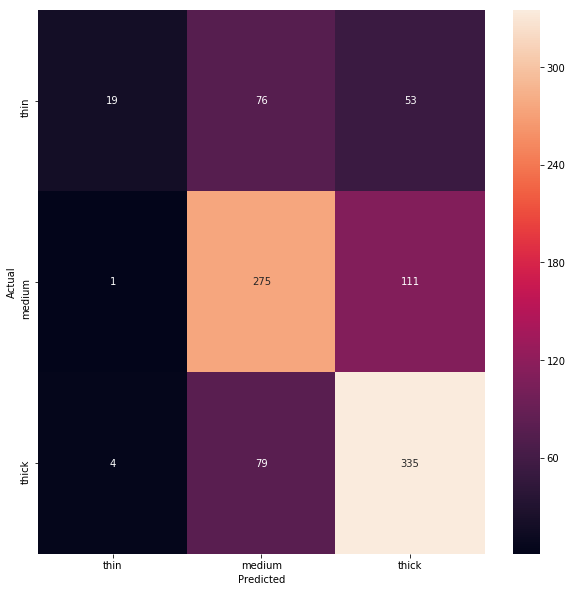

In [115]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(features_den, labels_den, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=density_no_nan_df.density.unique(), yticklabels=density_no_nan_df.density.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Texture prediction model

In [111]:
# make a data fram with no nulls in the different characteristics
texture_no_nan_df = cleaned_df[pd.notnull(cleaned_df['texture'])]
texture_no_nan_df['texture_catagory'] = pd.Categorical(texture_no_nan_df.density)
texture_no_nan_df["texture_catagory"] = texture_no_nan_df["texture_catagory"].cat.codes
print(texture_no_nan_df.describe())
texture_no_nan_df.head()

       curl_catagory  texture_catagory
count    2418.000000       2418.000000
mean        3.479735          0.007031
std         1.977062          1.206259
min        -1.000000         -1.000000
25%         2.000000         -1.000000
50%         4.000000         -1.000000
75%         5.000000          1.000000
max         9.000000          2.000000


,curl_pattern,density,porosity,texture,products,curl_catagory,texture_catagory
7,3c,NaN,NaN,fine,natural since 2001 curl type with some length ...,6,-1
8,4a,NaN,NaN,fine,natural since 2001 curl type with some length ...,7,-1
11,3b,medium,normal,fine,hair strands avatar pic march 20th 2013 co w...,5,0
13,3a,NaN,normal,medium,color treated 5 years co wash suave naturals ...,4,-1
14,3b,NaN,normal,medium,color treated 5 years co wash suave naturals ...,5,-1


In [112]:
# Classes are relitivly imbalanced balanced
texture_no_nan_df.texture.value_counts()

fine      1795
medium     457
coarse     166
Name: texture, dtype: int64

In [113]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features_text = tfidf.fit_transform(texture_no_nan_df.products).toarray()
labels_text = texture_no_nan_df.texture

In [114]:
#Test some models now

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_text, labels_text, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.718759
LogisticRegression        0.743177
MultinomialNB             0.744418
RandomForestClassifier    0.742351
Name: accuracy, dtype: float64

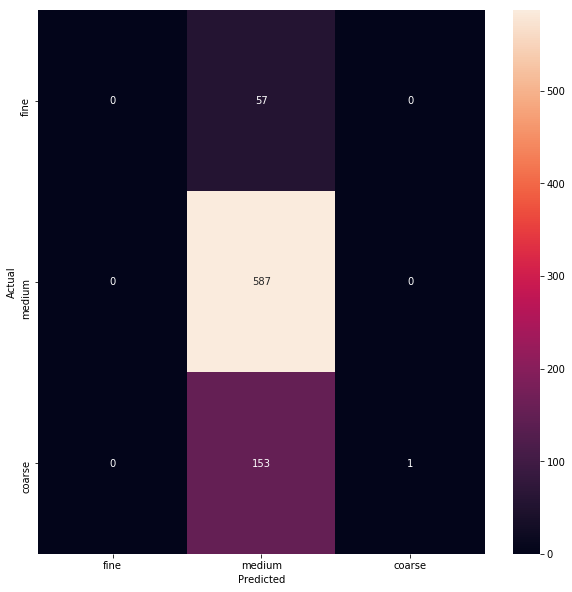

In [116]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(features_text, labels_text, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=texture_no_nan_df.texture.unique(), yticklabels=texture_no_nan_df.texture.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()